In [37]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import os
import json
import numpy as np
from dotenv import load_dotenv
from pycocotools.coco import COCO
from torch.utils.data import DataLoader, Dataset

In [2]:
load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
datasets_annotations_path = os.getenv('DATASET_ANNOTATIONS_PATH')
datasets_images_path = os.getenv('DATASET_IMAGES_PATH')

In [13]:
# dataType='train'
# imageDir = 'D:/Datasets/riset_infor_dataset/Car_Damage_Coco_Dataset_Combined/images/{}/'.format(dataType)
# ann = "D:/Datasets/riset_infor_dataset/Car_Damage_Coco_Dataset_Combined/annotations/train.json"
# coco=COCO(ann)

from pycocotools.coco import COCO

dataType='/train/'
imageDir = datasets_images_path + dataType
ann = datasets_annotations_path + "/train.json"
coco=COCO(ann)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)

number of categories:  1
[{'id': 1, 'name': 'damage', 'supercategory': 'part'}]


In [10]:
image_ids = coco.getImgIds()
image_id = image_ids[9]  
image_info = coco.loadImgs(image_id)
print(image_info)

[{'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '20.jpg', 'flickr_url': '', 'height': 1024, 'id': 9, 'license': 1, 'width': 1024}]


In [11]:
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
print(annotations)

[{'area': 11475.999999999989, 'bbox': [423, 348, 250, 256], 'category_id': 1, 'id': 31, 'image_id': 9, 'iscrowd': 0, 'segmentation': [[423, 601, 439, 533, 461, 515, 471, 498, 473, 481, 492, 472, 541, 428, 579, 406, 611, 389, 636, 373, 664, 348, 665, 368, 673, 382, 636, 432, 610, 467, 588, 500, 563, 546, 547, 566, 509, 582, 466, 595, 442, 604]]}, {'area': 3773.000000000001, 'bbox': [289, 523, 62, 80], 'category_id': 1, 'id': 32, 'image_id': 9, 'iscrowd': 0, 'segmentation': [[318, 523, 346, 530, 340, 567, 340, 580, 351, 597, 306, 603, 289, 597, 304, 559, 304, 544]]}, {'area': 28886.000000000793, 'bbox': [328, 256, 273, 300], 'category_id': 1, 'id': 33, 'image_id': 9, 'iscrowd': 0, 'segmentation': [[536, 256, 445, 328, 350, 452, 328, 525, 332, 556, 364, 556, 417, 542, 450, 490, 500, 419, 542, 403, 584, 369, 601, 336, 594, 307, 588, 281, 573, 263]]}]


[31, 32, 33]
Annotations for Image ID 9:
20.jpg


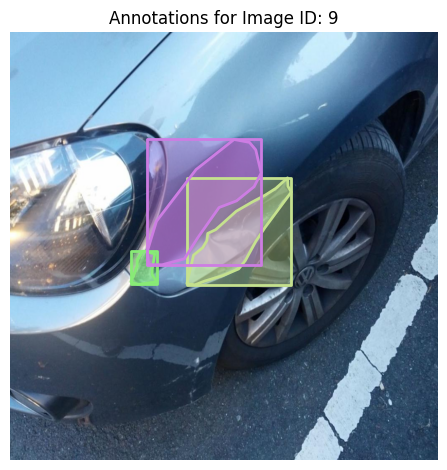

In [14]:
import matplotlib.pyplot as plt

imgId = 9

ann_ids = coco.getAnnIds(imgIds=[imgId], iscrowd=None)
print(ann_ids)

print(f"Annotations for Image ID {imgId}:")
anns = coco.loadAnns(ann_ids)

image_path = coco.loadImgs(imgId)[0]['file_name']
print(image_path)
image = plt.imread(imageDir + image_path)
plt.imshow(image)

# Display the specified annotations
coco.showAnns(anns, draw_bbox=True)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(image_id))
plt.tight_layout()
plt.show()

In [55]:
def load_annotations(annotations_path):
    """
    Memuat anotasi dari file JSON.
    
    Args:
        annotations_path (str): Path ke file JSON anotasi.
    
    Returns:
        List[dict]: Daftar anotasi dalam format dictionary.
    """
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)  # Load file JSON
    return annotations

def load_image(image_path):
    """
    Memuat gambar dari path menggunakan PIL.
    
    Args:
        image_path (str): Path ke file gambar.
        
    Returns:
        PIL.Image.Image: Gambar yang telah dimuat.
    """
    return Image.open(image_path).convert("RGB")



In [61]:
# 1. Dataset Customization
class CarDamageDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations = load_annotations(annotations_path)  # Fungsi sebelumnya
        self.transforms = transforms

    def __getitem__(self, idx):
        # Ambil data anotasi untuk indeks tertentu
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        img_path = os.path.join(self.images_path, image_id)

        # Muat gambar menggunakan fungsi load_image
        img = load_image(img_path)

        # Ambil target (bounding box dan label)
        target = {
            "boxes": torch.tensor(annotation['boxes'], dtype=torch.float32),
            "labels": torch.tensor(annotation['labels'], dtype=torch.int64)
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.annotations)


In [57]:
class CustomTransform:
    def __call__(self, image, target):
        # Transformasi pada image
        image = F.to_tensor(image)
        # Transformasi tambahan pada target jika diperlukan
        return image, target

In [58]:
# 2. Data Transforms
def get_transforms():
    return CustomTransform()


In [63]:
# 3. Load Dataset
train_annotations_path = os.path.join(datasets_annotations_path, "train.json")
val_annotations_path = os.path.join(datasets_annotations_path, "val.json")
train_images_path = datasets_images_path + "/train"
val_images_path = datasets_images_path + "/val"

train_dataset = CarDamageDataset(
    train_images_path, train_annotations_path, transforms=get_transforms()
)
val_dataset = CarDamageDataset(
    val_images_path, val_annotations_path, transforms=get_transforms()
)

In [18]:
# 4. Model Initialization
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn(weights=weights)

num_classes = 2  # Background + 1 class (Car-Damage)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU / CPU yang digunakan:", torch.cuda.get_device_name(0))
model.to(device)


GPU / CPU yang digunakan: NVIDIA GeForce RTX 3050 Laptop GPU


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [64]:
# 5. Load DataLoader untuk training dan validation dataset
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [65]:
num_epochs = 2

# Mengganti optimizer dengan Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# History untuk menyimpan loss per epoch
history = {'train_loss': []}

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # Untuk menyimpan total loss per epoch
    
    for images, targets in train_data_loader:  # Ganti data_loader dengan train_data_loader
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_epoch_loss = epoch_loss / len(train_data_loader)  # Rata-rata loss untuk epoch
    history['train_loss'].append(avg_epoch_loss)  # Menyimpan loss ke dalam history
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Menampilkan history
print("Training completed!")

# Plot Loss per Epoch
plt.plot(range(1, num_epochs+1), history['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()


KeyError: 3

In [50]:
# 6. Training Loop
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 2

# History untuk menyimpan loss per epoch
history = {'train_loss': []}

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # Untuk menyimpan total loss per epoch
    
    for images, targets in train_data_loader:  # Ganti data_loader dengan train_data_loader
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_epoch_loss = epoch_loss / len(train_data_loader)  # Rata-rata loss untuk epoch
    history['train_loss'].append(avg_epoch_loss)  # Menyimpan loss ke dalam history
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Menampilkan history
print("Training completed!")

# Plot Loss per Epoch
plt.plot(range(1, num_epochs+1), history['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()


AttributeError: Can't pickle local object 'get_transforms.<locals>.transforms'

In [ ]:
# 6. Evaluation and Visualization
def visualize_detection(image, predictions):
    image = image.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    for box in predictions['boxes']:
        xmin, ymin, xmax, ymax = box.int().tolist()
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          fill=False, color="red", linewidth=2))

    plt.axis("off")
    plt.show()

In [ ]:
# 7. Load and Test Model on New Image
model.eval()
test_image, _ = dataset[0]  # Test image
with torch.no_grad():
    prediction = model([test_image.to(device)])[0]

visualize_detection(test_image, prediction)